This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# xarray ODIM backend

In this example, we read ODIM_H5 (HDF5) data files using the xarray `odim` backend.

In [1]:
import glob
import os
import wradlib as wrl
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as pl
import numpy as np
import xarray as xr
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
from wradlib.io import open_odim_dataset

## Load ODIM_H5 Volume Data

In [2]:
fpath = 'hdf5/knmi_polar_volume.h5'
f = wrl.util.get_wradlib_data_file(fpath)
vol = wrl.io.open_odim_dataset(f)

### Inspect RadarVolume

In [3]:
display(vol)

<wradlib.RadarVolume>
Dimension(s): (sweep: 14)
Elevation(s): (0.3, 0.4, 0.8, 1.1, 2.0, 3.0, 4.5, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0, 25.0)

### Inspect root group

The `sweep` dimension contains the number of scans in this radar volume. Further the dataset consists of variables (location coordinates, time_coverage) and attributes (Conventions, metadata).

In [4]:
vol.root

<xarray.Dataset>
Dimensions:              (sweep: 14)
Coordinates:
    time                 datetime64[ns] 2011-06-10T11:40:02
    sweep_mode           <U20 'azimuth_surveillance'
    longitude            float64 4.79
    altitude             float64 50.0
    latitude             float64 52.95
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2011-06-10T11:40:02Z'
    time_coverage_end    <U20 '2011-06-10T11:43:54Z'
    sweep_group_name     (sweep) <U8 'sweep_0' 'sweep_1' ... 'sweep_13'
    sweep_fixed_angle    (sweep) float64 0.3 0.4 0.8 1.1 ... 12.0 15.0 20.0 25.0
Attributes:
    version:          None
    title:            None
    institution:      None
    references:       None
    source:           None
    history:          None
    comment:          im/exported using wradlib
    instrument_name:  None
    fixed_angle:      0.30000001192092896

### Inspect sweep group(s)

The sweep-groups can be accessed via their respective keys. The dimensions consist of `range` and `time` with added coordinates `azimuth`, `elevation`, `range` and `time`. There will be variables like radar moments (DBZH etc.) and sweep-dependend metadata (like `fixed_angle`, `sweep_mode` etc.).

In [5]:
display(vol[0])

<xarray.Dataset>
Dimensions:     (azimuth: 360, range: 320)
Coordinates:
  * azimuth     (azimuth) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    elevation   (azimuth) float32 ...
    rtime       (azimuth) datetime64[ns] 2011-06-10T11:40:17.361118208 ... 20...
  * range       (range) float32 500.0 1.5e+03 2.5e+03 ... 3.185e+05 3.195e+05
    time        datetime64[ns] 2011-06-10T11:40:02
    sweep_mode  <U20 ...
    longitude   float64 ...
    latitude    float64 ...
    altitude    float64 ...
Data variables:
    DBZH        (azimuth, range) float32 ...
Attributes:
    fixed_angle:  0.30000001192092896

### Goereferencing

In [6]:
swp = vol[0].copy().pipe(wrl.georef.georeference_dataset)

### Plotting

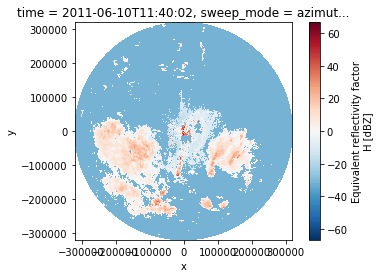

In [7]:
swp.DBZH.plot.pcolormesh(x='x', y='y')
pl.gca().set_aspect('equal')

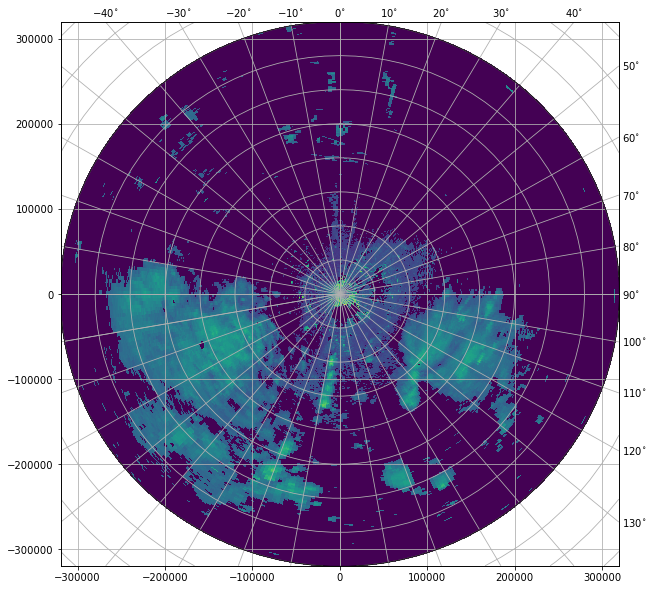

In [8]:
fig = pl.figure(figsize=(10,10))
swp.DBZH.wradlib.plot_ppi(proj='cg', fig=fig)

In [9]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

map_trans = ccrs.AzimuthalEquidistant(central_latitude=swp.latitude.values, 
                                      central_longitude=swp.longitude.values)

< GeoAxes: <cartopy.crs.AzimuthalEquidistant object at 0x7fae1d4b0180> >


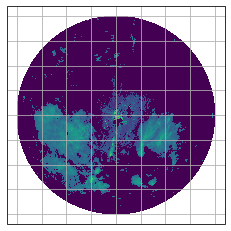

In [10]:
map_proj = ccrs.AzimuthalEquidistant(central_latitude=swp.latitude.values, 
                                      central_longitude=swp.longitude.values)
pm = swp.DBZH.wradlib.plot_ppi(proj=map_proj)
ax = pl.gca()
ax.gridlines(crs=map_proj)
print(ax)

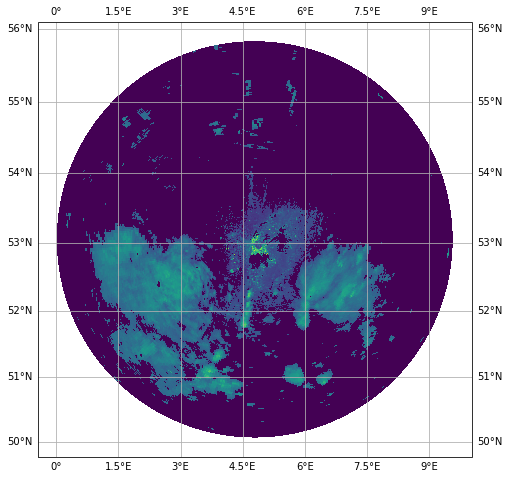

In [11]:
map_proj = ccrs.Mercator(central_longitude=swp.longitude.values)
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection=map_proj)
pm = swp.DBZH.wradlib.plot_ppi(ax=ax)
ax.gridlines(draw_labels=True)

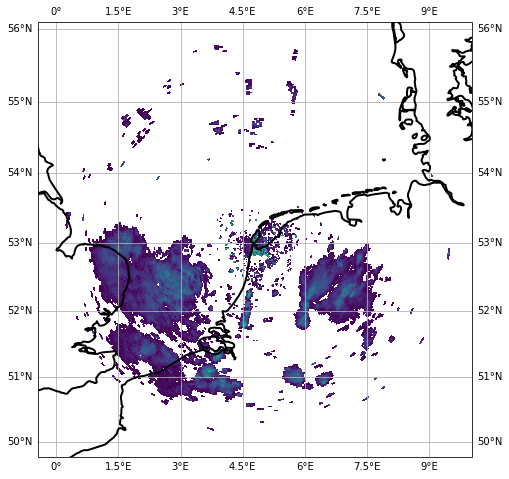

In [12]:
import cartopy.feature as cfeature
def plot_borders(ax):
    borders = cfeature.NaturalEarthFeature(category='physical',
                                           name='coastline',
                                           scale='10m',
                                           facecolor='none')
    ax.add_feature(borders, edgecolor='black', lw=2, zorder=4)

map_proj = ccrs.Mercator(central_longitude=swp.longitude.values)
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection=map_proj)

DBZH = swp.DBZH
pm = DBZH.where(DBZH > 0).wradlib.plot_ppi(ax=ax)
plot_borders(ax)
ax.gridlines(draw_labels=True)

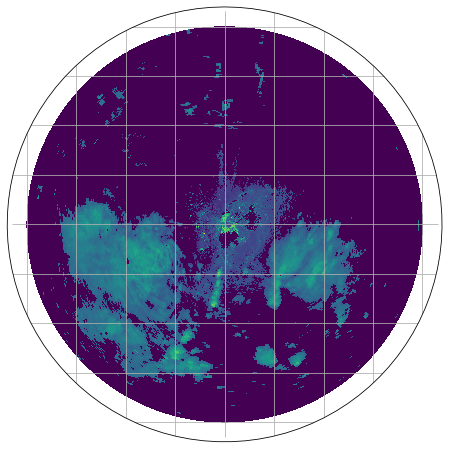

In [13]:
import matplotlib.path as mpath
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

map_proj = ccrs.AzimuthalEquidistant(central_latitude=swp.latitude.values, 
                                     central_longitude=swp.longitude.values,
                                    )
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection=map_proj)
ax.set_boundary(circle, transform=ax.transAxes)

pm = swp.DBZH.wradlib.plot_ppi(proj=map_proj, ax=ax)
ax = pl.gca()
ax.gridlines(crs=map_proj)

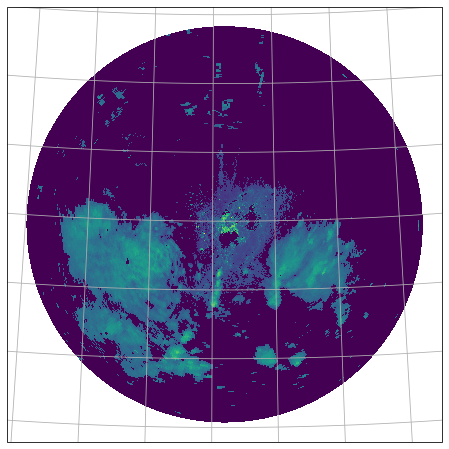

In [14]:
fig = pl.figure(figsize=(10, 8))
proj=ccrs.AzimuthalEquidistant(central_latitude=swp.latitude.values, 
                               central_longitude=swp.longitude.values)
ax = fig.add_subplot(111, projection=proj)
pm = swp.DBZH.wradlib.plot_ppi(ax=ax)
ax.gridlines()

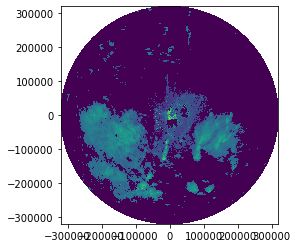

In [15]:
swp.DBZH.wradlib.plot_ppi()

### Inspect radar moments

The DataArrays can be accessed by key or by attribute. Each DataArray has dimensions and coordinates of it's parent dataset. There are attributes connected which are defined by ODIM_H5 standard.

In [16]:
display(swp.DBZH)

<xarray.DataArray 'DBZH' (azimuth: 360, range: 320)>
array([[ 22. ,  17. ,  -8. , ..., -31.5, -31.5, -31.5],
       [ 24. ,  24.5,  -9. , ..., -31.5, -31.5, -31.5],
       [ 35.5,  42. ,  12. , ..., -31.5, -31.5, -31.5],
       ...,
       [ 23. ,  14. , -13. , ..., -31.5, -31.5, -31.5],
       [ 23. ,  14. ,  -9. , ..., -31.5, -31.5, -31.5],
       [ 22. ,  18.5, -11.5, ..., -31.5, -31.5, -31.5]], dtype=float32)
Coordinates: (12/15)
  * azimuth     (azimuth) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    elevation   (azimuth) float32 0.3 0.3 0.3 0.3 0.3 ... 0.3 0.3 0.3 0.3 0.3
    rtime       (azimuth) datetime64[ns] 2011-06-10T11:40:17.361118208 ... 20...
  * range       (range) float32 500.0 1.5e+03 2.5e+03 ... 3.185e+05 3.195e+05
    time        datetime64[ns] 2011-06-10T11:40:02
    sweep_mode  <U20 'azimuth_surveillance'
    ...          ...
    x           (azimuth, range) float32 4.363 13.09 ... -2.777e+03 -2.786e+03
    y           (azimuth, range) float32 500.0 1.5e+03 ... 3.183e+05 3.193e+05
    z           (azimuth, range) float32 53.0 58.0 64.0 ... 7.691e+03 7.734e+03
    gr          (azimuth, range) float32 500.0 1.5e+03 ... 3.183e+05 3.193e+05
    rays        (azimuth, range) float32 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5
    bins        (azimuth, range) float32 500.0 1.5e+03 ... 3.185e+05 3.195e+05
Attributes:
    _Undetect:      [0.]
    units:          dBZ
    long_name:      Equivalent reflectivity factor H
    standard_name:  radar_equivalent_reflectivity_factor_h

### Create simple plot

Using xarray features a simple plot can be created like this. Note the `sortby('rtime')` method, which sorts the radials by time.

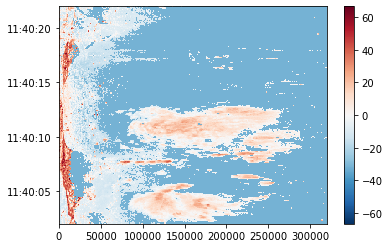

In [17]:
swp.DBZH.sortby('rtime').plot(x="range", y="rtime", add_labels=False)

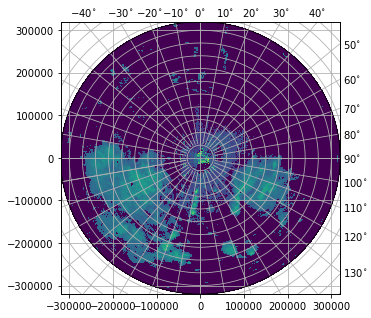

In [18]:
fig = pl.figure(figsize=(5,5))
pm = swp.DBZH.wradlib.plot_ppi(proj={'latmin': 33e3}, fig=fig)

### Mask some values

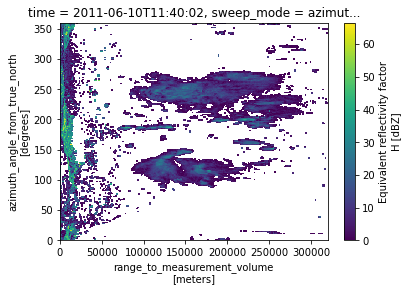

In [19]:
swp['DBZH'] = swp['DBZH'].where(swp['DBZH'] >= 0)
swp['DBZH'].plot()

### Export to ODIM and CfRadial2

In [20]:
vol.to_odim('knmi_odim.h5')
vol.to_cfradial2('knmi_odim_as_cfradial.nc')

### Import again

In [21]:
vola = wrl.io.open_odim_dataset('knmi_odim.h5')

In [22]:
volb = wrl.io.open_cfradial2_dataset('knmi_odim_as_cfradial.nc')

### Check equality

In [23]:
xr.testing.assert_allclose(vol.root, vola.root)
xr.testing.assert_equal(vol[0], vola[0])
xr.testing.assert_allclose(vol.root, volb.root)
xr.testing.assert_equal(vol[0], volb[0])
xr.testing.assert_allclose(vola.root, volb.root)
xr.testing.assert_equal(vola[0], volb[0])

AssertionError: Left and right Dataset objects are not equal

Differing coordinates:
L * azimuth     (azimuth) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
R * azimuth     (azimuth) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
L   rtime       (azimuth) datetime64[ns] 2011-06-10T11:40:17.361118208 ... 20...
R   rtime       (azimuth) datetime64[ns] 2011-06-10T11:40:17.361118208 ... 20...
L   elevation   (azimuth) float32 0.3 0.3 0.3 0.3 0.3 ... 0.3 0.3 0.3 0.3 0.3
R   elevation   (azimuth) float32 0.3 0.3 0.3 0.3 0.3 ... 0.3 0.3 0.3 0.3 0.3
Differing data variables:
L   DBZH        (azimuth, range) float32 22.0 17.0 -8.0 ... -31.5 -31.5 -31.5
R   DBZH        (azimuth, range) float32 22.0 17.0 -8.0 ... -31.5 -31.5 -31.5

## More ODIM loading mechanisms

### Use `xr.open_dataset` to retrieve explicit group

In [ ]:
swp = xr.open_dataset(f, engine="odim", group="dataset14")
display(swp)

### Use `xr.open_mfdataset` to retrieve timeseries of explicit group 

In [ ]:
fpath = os.path.join(wrl.util.get_wradlib_data_path(), "hdf5/71*.h5")
f = glob.glob(fpath)
ts = xr.open_mfdataset(f, engine="odim", concat_dim="time", combine="nested", group="dataset1")
display(ts)

### Use `wrl.io.open_odim_mfdataset` to retrieve volume timeseries  

In [ ]:
fpath = os.path.join(wrl.util.get_wradlib_data_path(), "hdf5/71*.h5")
f = glob.glob(fpath)
ts = wrl.io.open_odim_mfdataset(f)
display(ts)

In [ ]:
display(ts[0])